In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load the preprocessed training dataset
data_path = '/content/drive/MyDrive/Datasets/UNSW-NB15/MyTechniques/preprocessed_training_set.csv'  # Update with the correct path
df = pd.read_csv(data_path)

In [ ]:
# Analyze class distribution
class_counts = df['attack_cat'].value_counts()
print("Class Distribution in Testing Set:\n", class_counts)

Class Distribution in Testing Set:
 attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64


In [ ]:
# Drop the 'labels' and 'attack_cat' columns
df = df.drop(columns=['label', 'attack_cat'])

In [ ]:
# Assume `data` is your input dataset
scaler = MinMaxScaler(feature_range=(-1, 1))  # Scale to [-1, 1]
normalized_data = scaler.fit_transform(df)

In [ ]:
# Convert data to PyTorch tensors
data = torch.tensor(normalized_data, dtype=torch.float32)

In [ ]:
# Define dimensions
input_dim = data.shape[1]
latent_dim = 100  # Dimension of the noise vector

In [ ]:
# ---------------------
# Define Generator
# ---------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# ---------------------
# Define Discriminator
# ---------------------
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize models
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

In [ ]:
# Define Custom Loss (Scaled MSE Loss)
class CustomGANLoss(nn.Module):
    def __init__(self):
        super(CustomGANLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        # Scale the loss to [0, 1] by taking the mean squared error
        return self.mse(predictions, targets)

In [ ]:
# Loss and Optimizers
# Replace BCELoss with CustomGANLoss
bce_loss = nn.BCELoss()
mse_loss =  CustomGANLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Normalize BCELoss
def normalized_bce_loss(predictions, targets):
    loss = bce_loss(predictions, targets)
    # Normalize the loss between 0 and 1
    normalized_loss = loss / torch.max(loss, torch.tensor(1.0))  # Avoid division by 0
    return normalized_loss

In [ ]:
def train_gan(epochs, batch_size, data):
    batch_count = data.shape[0] // batch_size
    d_losses, g_losses, accuracies = [], [], []

    for epoch in range(epochs):
        epoch_d_loss, epoch_g_loss, epoch_acc = 0, 0, 0

        for batch in range(batch_count):
            # Train Discriminator
            real_samples = data[torch.randint(0, data.shape[0], (batch_size,))]
            real_labels = torch.ones((batch_size, 1))  # Real labels as 1

            noise = torch.randn((batch_size, latent_dim))
            fake_samples = generator(noise)
            fake_labels = torch.zeros((batch_size, 1))  # Fake labels as 0

            # Real Loss (BCELoss)
            real_loss = bce_loss(discriminator(real_samples), real_labels)
            # Fake Loss (BCELoss)
            fake_loss = bce_loss(discriminator(fake_samples.detach()), fake_labels)
            d_loss = real_loss + fake_loss

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # Train Generator (MSELoss)
            misleading_labels = torch.ones((batch_size, 1))  # Generator aims to mislead as "real"
            g_loss = mse_loss(discriminator(fake_samples), misleading_labels)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

            # Accumulate losses for the epoch
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()

            # Calculate batch accuracy
            real_pred = discriminator(real_samples).round()
            fake_pred = discriminator(fake_samples).round()
            acc = (real_pred.eq(real_labels).sum().item() + fake_pred.eq(fake_labels).sum().item()) / (2 * batch_size)
            epoch_acc += acc

        # Average losses and accuracy for the epoch
        d_losses.append(epoch_d_loss / batch_count)
        g_losses.append(epoch_g_loss / batch_count)
        accuracies.append(epoch_acc / batch_count)

        # Print Epoch Progress
        print(f"Epoch [{epoch + 1}/{epochs}] completed.")
        print(
            f"Discriminator Loss: {d_losses[-1]:.4f} | Generator Loss: {g_losses[-1]:.4f} | Accuracy: {accuracies[-1]:.4f}"
        )

    # Plot Final Graphs
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    # Losses Graph
    ax[0].plot(range(1, epochs + 1), d_losses, label="Discriminator Loss", color="red", marker='o')
    ax[0].plot(range(1, epochs + 1), g_losses, label="Generator Loss", color="blue", marker='o')
    ax[0].legend()
    ax[0].set_title("Losses (Generator vs Discriminator)")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")

    # Accuracy Graph
    ax[1].plot(range(1, epochs + 1), accuracies, label="Accuracy", color="green", marker='o')
    ax[1].legend()
    ax[1].set_title("Training Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


Epoch [1/1000] completed.
Discriminator Loss: 0.8559 | Generator Loss: 0.5329 | Accuracy: 0.8428
Epoch [2/1000] completed.
Discriminator Loss: 0.9225 | Generator Loss: 0.4852 | Accuracy: 0.7738
Epoch [3/1000] completed.
Discriminator Loss: 1.1482 | Generator Loss: 0.3936 | Accuracy: 0.7027
Epoch [4/1000] completed.
Discriminator Loss: 1.1857 | Generator Loss: 0.3637 | Accuracy: 0.6866
Epoch [5/1000] completed.
Discriminator Loss: 1.1612 | Generator Loss: 0.3756 | Accuracy: 0.7006
Epoch [6/1000] completed.
Discriminator Loss: 1.1492 | Generator Loss: 0.3820 | Accuracy: 0.7109
Epoch [7/1000] completed.
Discriminator Loss: 1.1465 | Generator Loss: 0.3854 | Accuracy: 0.7073
Epoch [8/1000] completed.
Discriminator Loss: 1.1386 | Generator Loss: 0.3865 | Accuracy: 0.7132
Epoch [9/1000] completed.
Discriminator Loss: 1.1374 | Generator Loss: 0.3839 | Accuracy: 0.7066
Epoch [10/1000] completed.
Discriminator Loss: 1.1326 | Generator Loss: 0.3873 | Accuracy: 0.7093
Epoch [11/1000] completed.
Di

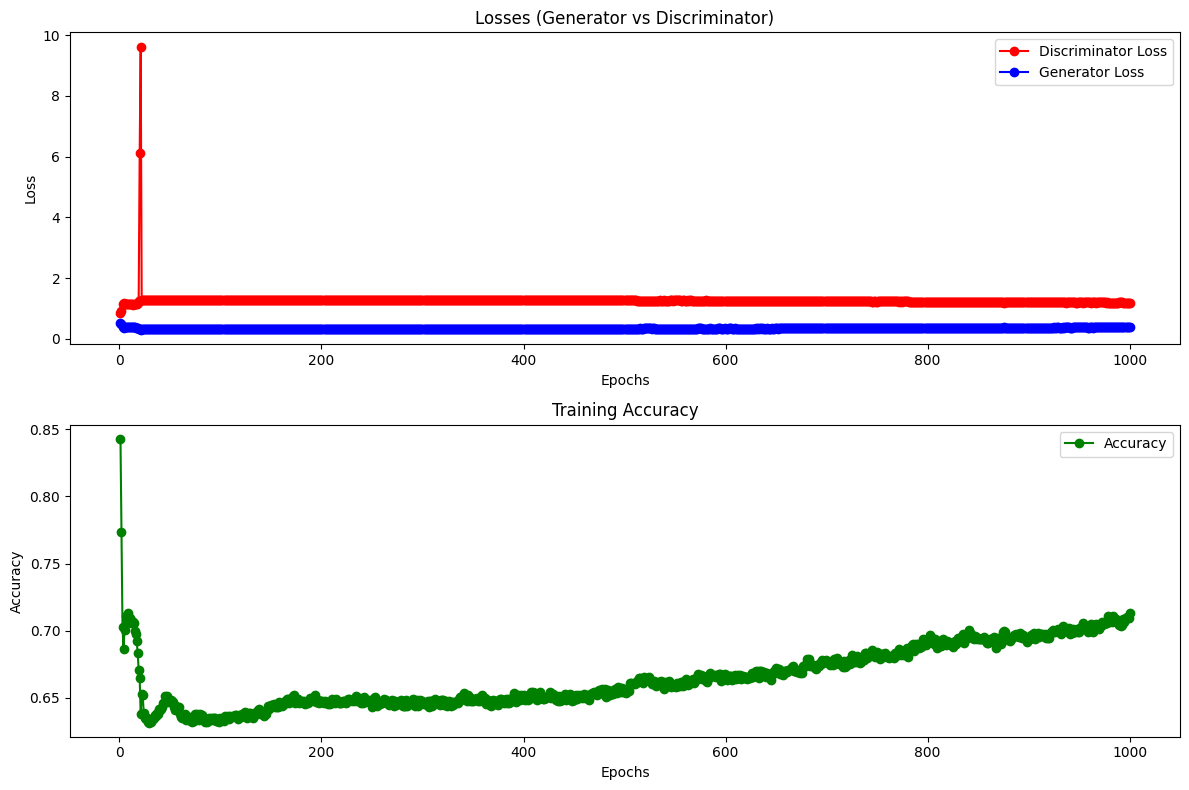

In [ ]:
# Train GAN
train_gan(epochs=1000, batch_size=64, data=data)

In [ ]:
# Save Models
torch.save(generator.state_dict(), "/content/drive/MyDrive/gan_generator.pth")
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/gan_discriminator.pth")

In [ ]:
# Load the trained generator and discriminator
generator.load_state_dict(torch.load("/content/drive/MyDrive/gan_generator.pth", map_location=torch.device('cpu')))
generator.eval()

discriminator.load_state_dict(torch.load("/content/drive/MyDrive/gan_discriminator.pth", map_location=torch.device('cpu')))
discriminator.eval()

<ipython-input-13-0c8bb1eeb230>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/content/drive/MyDrive/gan_generator.pth", map_locatio

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
# Testing dataset path
test_data_path = '/content/drive/MyDrive/Datasets/UNSW-NB15/MyTechniques/preprocessed_testing_set.csv'
test_df = pd.read_csv(test_data_path)

In [ ]:
# Analyze class distribution
class_counts = test_df['attack_cat'].value_counts()
print("Class Distribution in Testing Set:\n", class_counts)

Class Distribution in Testing Set:
 attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


In [ ]:
# Set the target count to balance all classes to the maximum class count
target_count = class_counts.max()
minority_classes = class_counts[class_counts < target_count].index.tolist()
print(f"Identified Minority Classes: {minority_classes}")

Identified Minority Classes: ['Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']


In [ ]:
# Initialize a balanced testing set DataFrame
balanced_test_df = test_df.copy()

In [ ]:
# Get feature columns (excluding 'label' and 'attack_cat')
feature_columns = test_df.columns.difference(['label', 'attack_cat'])
num_features = len(feature_columns)

In [ ]:
# Initialize lists to store scores for plotting
real_scores = []
generated_scores = []

Generating 16000 samples for class: Generic
Accuracy of generated samples for class Generic: 19.79%
Generating 22607 samples for class: Exploits
Accuracy of generated samples for class Exploits: 19.79%
Generating 37816 samples for class: Fuzzers
Accuracy of generated samples for class Fuzzers: 19.45%
Generating 43736 samples for class: DoS
Accuracy of generated samples for class DoS: 19.44%
Generating 45509 samples for class: Reconnaissance
Accuracy of generated samples for class Reconnaissance: 19.61%
Generating 54000 samples for class: Analysis
Accuracy of generated samples for class Analysis: 19.73%
Generating 54254 samples for class: Backdoor
Accuracy of generated samples for class Backdoor: 19.60%
Generating 54867 samples for class: Shellcode
Accuracy of generated samples for class Shellcode: 19.61%
Generating 55870 samples for class: Worms
Accuracy of generated samples for class Worms: 19.73%
Balanced testing set saved to /content/drive/MyDrive/Datasets/UNSW-NB15/MyTechniques/bal

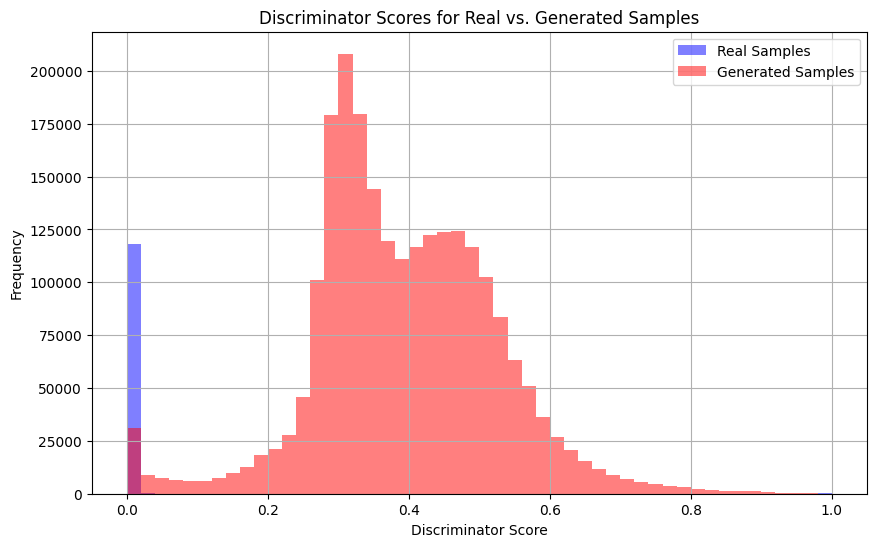

Real Samples - Mean: 0.0056, Std Dev: 0.0692
Generated Samples - Mean: 0.3927, Std Dev: 0.1304
Inception-like Score: 0.3871


In [ ]:
# Generate synthetic samples for minority classes and filter them using the discriminator
for minority_class in minority_classes:
    # Filter samples for the current minority class
    minority_samples = test_df[test_df['attack_cat'] == minority_class]
    current_count = len(minority_samples)
    samples_to_generate = target_count - current_count

    print(f"Generating {samples_to_generate} samples for class: {minority_class}")

    # Generate synthetic samples
    noise = torch.randn((samples_to_generate * 2, latent_dim))  # Generate extra samples for filtering
    synthetic_samples = generator(noise).detach()

    # Ensure the generator outputs the correct number of features
    if synthetic_samples.shape[1] != num_features:
        raise ValueError(f"Mismatch in feature dimensions. Expected {num_features}, but got {synthetic_samples.shape[1]}")

    # Use the discriminator to evaluate the quality of synthetic samples
    discriminator_scores = discriminator(synthetic_samples).detach().numpy().flatten()

    # Record discriminator scores for generated samples
    generated_scores.extend(discriminator_scores)

    # Calculate accuracy of the generated samples
    real_threshold = 0.5  # Assuming a threshold for the discriminator to classify a sample as real
    accuracy = np.mean(discriminator_scores > real_threshold)
    print(f"Accuracy of generated samples for class {minority_class}: {accuracy * 100:.2f}%")

    # Select the top N samples based on discriminator scores
    top_indices = discriminator_scores.argsort()[-samples_to_generate:]  # Get the best samples
    selected_samples = synthetic_samples[top_indices].numpy()

    # Denormalize synthetic samples (if normalization was applied earlier)
    data_min = test_df[feature_columns].min().values  # Extract min values for features
    data_max = test_df[feature_columns].max().values  # Extract max values for features
    selected_samples = selected_samples * (data_max - data_min) + data_min

    # Create a DataFrame for the selected synthetic samples
    synthetic_df = pd.DataFrame(selected_samples, columns=feature_columns)
    synthetic_df['label'] = 1  # Assuming 1 indicates 'attack'
    synthetic_df['attack_cat'] = minority_class  # Assign the class label

    # Add synthetic samples to the testing set
    balanced_test_df = pd.concat([balanced_test_df, synthetic_df], ignore_index=True)

# Record discriminator scores for real samples
real_samples = test_df[test_df['attack_cat'].isin(minority_classes)]
real_samples_features = torch.tensor(real_samples[feature_columns].values, dtype=torch.float32)
real_scores = discriminator(real_samples_features).detach().numpy().flatten()

# Save the balanced testing set
balanced_test_data_path = '/content/drive/MyDrive/Datasets/UNSW-NB15/MyTechniques/balanced_testing_set.csv'
balanced_test_df.to_csv(balanced_test_data_path, index=False)

print(f"Balanced testing set saved to {balanced_test_data_path}")
class_counts = balanced_test_df['attack_cat'].value_counts()
print("Class Distribution in Balanced Testing Set:\n", class_counts)

# Plot the discriminator scores for real and generated samples
plt.figure(figsize=(10, 6))
plt.hist(real_scores, bins=50, alpha=0.5, label='Real Samples', color='blue')
plt.hist(generated_scores, bins=50, alpha=0.5, label='Generated Samples', color='red')
plt.title('Discriminator Scores for Real vs. Generated Samples')
plt.xlabel('Discriminator Score')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Evaluation metrics (Mean and Standard Deviation)
real_mean = np.mean(real_scores)
real_std = np.std(real_scores)
generated_mean = np.mean(generated_scores)
generated_std = np.std(generated_scores)

print(f"Real Samples - Mean: {real_mean:.4f}, Std Dev: {real_std:.4f}")
print(f"Generated Samples - Mean: {generated_mean:.4f}, Std Dev: {generated_std:.4f}")

# Optional: Add Inception Score-like metric (simply evaluating the difference in mean scores)
inception_score = np.abs(real_mean - generated_mean)
print(f"Inception-like Score: {inception_score:.4f}")